# Inspection and Visualization of the Results
In case you didn't track the experiments with weights and biases, this Notebook inspects the results stored in the `/results` directory
Put the name of the dataset in `name` and the name of the knowledge enhanced model in `ke_model` and the base model in `base_model`

In [23]:
name='Cora' # choose from ['Cora', 'CiteSeer', 'PubMed', 'Flickr']
ke_model='Ke_GCN' # choose from ['Ke_MLP', 'Ke_GAT', 'Ke_GCN']
base_model='GCN' # choose from ['MLP', 'GAT', 'CN']

In [24]:
if name=='Cora':
    num_classes = 7
elif name=='CiteSeer':
    num_classes = 6
elif name=='Flickr':
    num_classes = 7
elif name=='PubMed':
    num_classes = 3
else:
    raise AttributeError('Wrong dataset specified.')


In [25]:
from scipy.stats import ttest_ind
import statistics
import numpy as np
from pathlib import Path
import pickle
import torch_geometric.datasets
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [26]:
path = Path().resolve().parent / 'Experiments' /'results'

In [27]:
# load results file and clause weight file
try:
    with open(path / str('results_'+name+'_'+ke_model), 'rb') as k_res_input:
        ke_results = pickle.load(k_res_input)

    with open(path / str('results_'+name+'_'+base_model), 'rb') as b_res_input:
        base_results = pickle.load(b_res_input)

    with open(path / str('clause_weights_'+name+'_'+ke_model), 'rb') as cw_input:
        clause_weights = pickle.load(cw_input)
    print('files loaded')
except FileNotFoundError:
    print(f'The results file for you specified does not exist. Run the experiments first or specify another file in the first cell of the notebook')


files loaded


In [28]:
num_runs = len(ke_results['test_accuracies'])
print(f' Number of runs: {num_runs}')

 Number of runs: 30


##  Print and Compare the Test Accuracies

In [29]:
print(f'Results on Dataset {name}, {ke_model} vs. {base_model}')
ke_test_accs = ke_results['test_accuracies']
base_test_accs = base_results['test_accuracies']
print(f'- Avg. Test Accuracy {ke_model}: {np.mean(ke_test_accs)}, Std: {np.std(ke_test_accs)}')
print(f'- Avg. Test Accuracy {base_model}: {np.mean(base_test_accs)}, Std: {np.std(base_test_accs)}')
print(f'- One-sided t-test, H1: test accuracy of {ke_model} > test accuracy of {base_model}: {ttest_ind(base_test_accs, ke_test_accs, alternative="less", equal_var=False)[1]}')
print(f'(p-values: independent two-sample ttest, alternative: kenn test accuracy > standard test accuracy)')


Results on Dataset Cora, Ke_GCN vs. GCN
- Avg. Test Accuracy Ke_GCN: 0.8475666666666668, Std: 0.00559573250095305
- Avg. Test Accuracy GCN: 0.8480999999999999, Std: 0.005274782775938113
- One-sided t-test, H1: test accuracy of Ke_GCN > test accuracy of GCN: 0.6449231062747023
(p-values: independent two-sample ttest, alternative: kenn test accuracy > standard test accuracy)


## Analysis of Clause Weights
Compute the a-priori clause compliance before running the experiments on the dataset.
It indicates how well each clause is satisfied, see notations in the paper.
Each values correspond to the respective Class Number $i$ and to the Clause:
$\forall (x,y): \neg Cls_i(x) \lor \neg Link(x,y) \lor Cls_i(y)$


In [30]:

def compute_compliance(data, num_classes):
    """
    compute clause compliance per iteration
    returns a list of length |number classes| with compliance value per each
    """
    # y = model.data.y.cpu().detach().numpy() do we need to detach or is this even slowing down the code?
    y = data.y.numpy()
    edge_index = np.transpose(data.edge_index.numpy())
    train_mask = data.train_mask.numpy()
    train_edge_mask = np.logical_or(train_mask[edge_index[:, 0]], train_mask[edge_index[:, 1]])

    # calculate the classes corresponding to edge index
    edge_index_cls = np.zeros_like(edge_index)
    for row in range(edge_index.shape[0]):
        edge_index_cls[row, 0] = y[edge_index[row, 0]]
        edge_index_cls[row, 1] = y[edge_index[row, 1]]

    compliance = []
    for cls in range(num_classes):
        cls_mask = np.logical_or(edge_index_cls[:, 0] == cls, edge_index_cls[:, 1] == cls)
        mask = np.logical_and(cls_mask, train_edge_mask) # edges that have at least a training node and a node of class cls
        same_mask = np.logical_and(mask, np.equal(edge_index_cls[:, 0], edge_index_cls[:, 1])) # edges that are of the above set and have the same class for both nodes
        cls_compliance = sum(same_mask)/sum(mask)
        compliance.append(cls_compliance)

    return compliance

In [31]:
[cora_dataset] = torch_geometric.datasets.Planetoid(root='Cora', name='Cora', split="full")
[citeseer_dataset] = torch_geometric.datasets.Planetoid(root='CiteSeer', name='CiteSeer', split="full")
[pubmed_dataset] = torch_geometric.datasets.Planetoid(root='PubMed', name='PubMed', split="full")
[flickr_dataset] = getattr(torch_geometric.datasets, 'Flickr')(root='Flickr')

In [32]:
print(f'Compliance Cora: {compute_compliance(cora_dataset, num_classes=7)}')
print(f'Compliance CiteSeer: {compute_compliance(citeseer_dataset, num_classes=6)}')
print(f'Compliance PubMed: {compute_compliance(pubmed_dataset, num_classes=3)}')
print(f'Compliance Flickr: {compute_compliance(flickr_dataset, num_classes=7)}')

Compliance Cora: [0.516, 0.657074340527578, 0.8295904887714664, 0.7107142857142857, 0.7214170692431562, 0.6339468302658486, 0.6179401993355482]
Compliance CiteSeer: [0.23054755043227665, 0.45161290322580644, 0.6481203007518797, 0.6135204081632653, 0.6585067319461444, 0.6395348837209303]
Compliance PubMed: [0.4921793534932221, 0.7432938400779607, 0.6903725205611998]
Compliance Flickr: [0.04393460436629458, 0.1334592655494515, 0.0741020871236125, 0.04512233049968899, 0.2411165573874849, 0.0328884652049571, 0.2782410646348999]


## Plot the Clause Compliance vs. the Leaned Clause Weights (for KeMLP)

Class 0, Layer 0: Mean of learned clause weight over runs: 0.08501725854972998, std clause weight: 0.030899171944924746
Class 1, Layer 0: Mean of learned clause weight over runs: 0.04527242324159791, std clause weight: 0.02614486971963924
Class 2, Layer 0: Mean of learned clause weight over runs: 0.07323108011235793, std clause weight: 0.03420397191797401
Class 3, Layer 0: Mean of learned clause weight over runs: 0.050132955017033964, std clause weight: 0.04455078953417294
Class 4, Layer 0: Mean of learned clause weight over runs: 0.053260646876879036, std clause weight: 0.03194927354672624
Class 5, Layer 0: Mean of learned clause weight over runs: 0.03467566988741358, std clause weight: 0.027965507708149515
Class 6, Layer 0: Mean of learned clause weight over runs: 0.05167101533152163, std clause weight: 0.033177529053717805


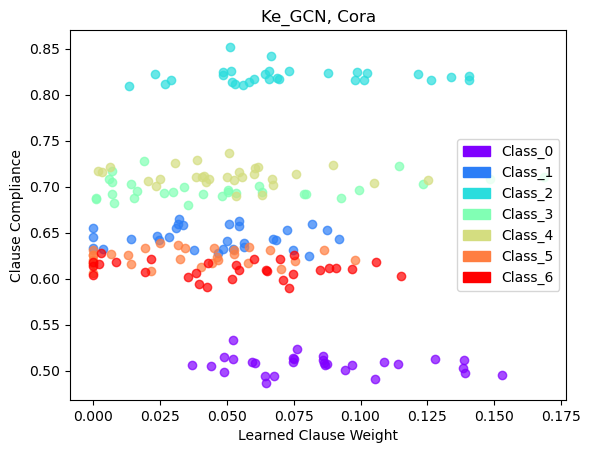

In [33]:

color = plt.cm.rainbow(np.linspace(0, 1, num_classes))


num_layers=1
for cls in range(num_classes):
    for layer in range(num_layers):
        cls_list = [clause_weights[i][layer][str(cls)][-1] for i in range(num_runs)]
        print(f'Class {cls}, Layer {layer}: Mean of learned clause weight over runs: {np.mean(cls_list)}, std clause weight: {np.std(cls_list)}')

plt.figure()
compliance = compute_compliance(cora_dataset, num_classes=num_classes)

class_labels = [str(i) for i in range(num_classes)]
patches = []
for k, j in enumerate(class_labels):
    patches.append(mpatches.Patch(color=color[k], label='Class_'+j))
    _list = [clause_weights[i][0][j][-1] for i in range(num_runs)]
    for i in _list:
        plt.scatter(i, compliance[k] + np.random.normal(-0.01, 0.01)
                    , color=color[k], alpha=0.7)

plt.ylabel('Clause Compliance')
plt.xlabel('Learned Clause Weight')
plt.legend(handles=patches)
plt.title(f'{ke_model}, {name}')
plt.show()



## Plot Clause Weight learning during training (epochs)
The plot is done for one specific run. If more than one run was executed, the `run` parameter can be modified to plot the clause weights over epoch for an arbitrary run.

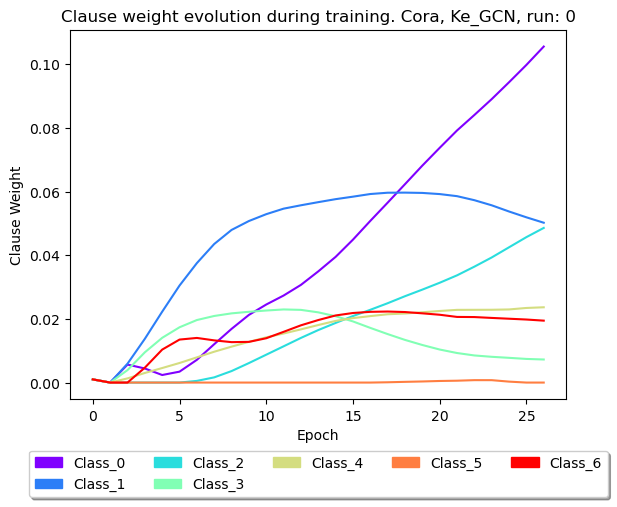

In [34]:
run = 0
patches = []
for k, j in enumerate(class_labels):
    patches.append(mpatches.Patch(color=color[k], label='Class_'+j))
    _list = clause_weights[run][0][j]
    plt.plot(_list, color=color[k])
plt.legend(handles=patches, loc='upper center', bbox_to_anchor=(0.5, -0.12),
           fancybox=True, shadow=True, ncol=5)
plt.ylabel('Clause Weight')
plt.xlabel('Epoch')
plt.title(f'Clause weight evolution during training. {name}, {ke_model}, run: {run}')
plt.show()